In [1]:
import numpy as np
from PYNQ_Car.CarOverlay.CarOverlay import CarOverlay
from xiaogong import PIDController
from pynq import GPIO
from PIL import Image
import IPython
import time
from pynq.xlnk import Xlnk
from pynq.lib.video.common import VideoMode
from PYNQ_Car.Infra.camera import Camera
from PYNQ_Car.Infra.MotionController import MotionController
import cv2
from pynq.lib.video.pipeline import PixelPacker
xlnk = Xlnk()
overlay = CarOverlay('/usr/local/lib/python3.6/dist-packages/PYNQ_Car/Overlay/Car.bit')

In [2]:
OV5640 = Camera(overlay.OV5640)
video_proc = overlay.video_proc
mc = MotionController(overlay.Arduino)

In [3]:
hdmi_out = overlay.video_output.axi_vdma.writechannel
out_unpack = overlay.video_output.pixel_unpack
hdmi_out.mode = VideoMode(1280,720,24)
out_unpack.bits_per_pixel = 24
overlay.OV5640.readchannel.tie(hdmi_out)
hdmi_out.start()

### 编写在notebook上显示图像的函数

In [4]:
def imshow_rgba(frame):
    image = Image.fromarray(frame)
    r, g, b = image.split()
    image = Image.merge('RGB', [r,g,b])
    IPython.display.clear_output(1)
    display(image)
def imshow_gray(frame):
    image = Image.fromarray(frame)
    IPython.display.clear_output(1)
    display(image)

### 显示测试通道

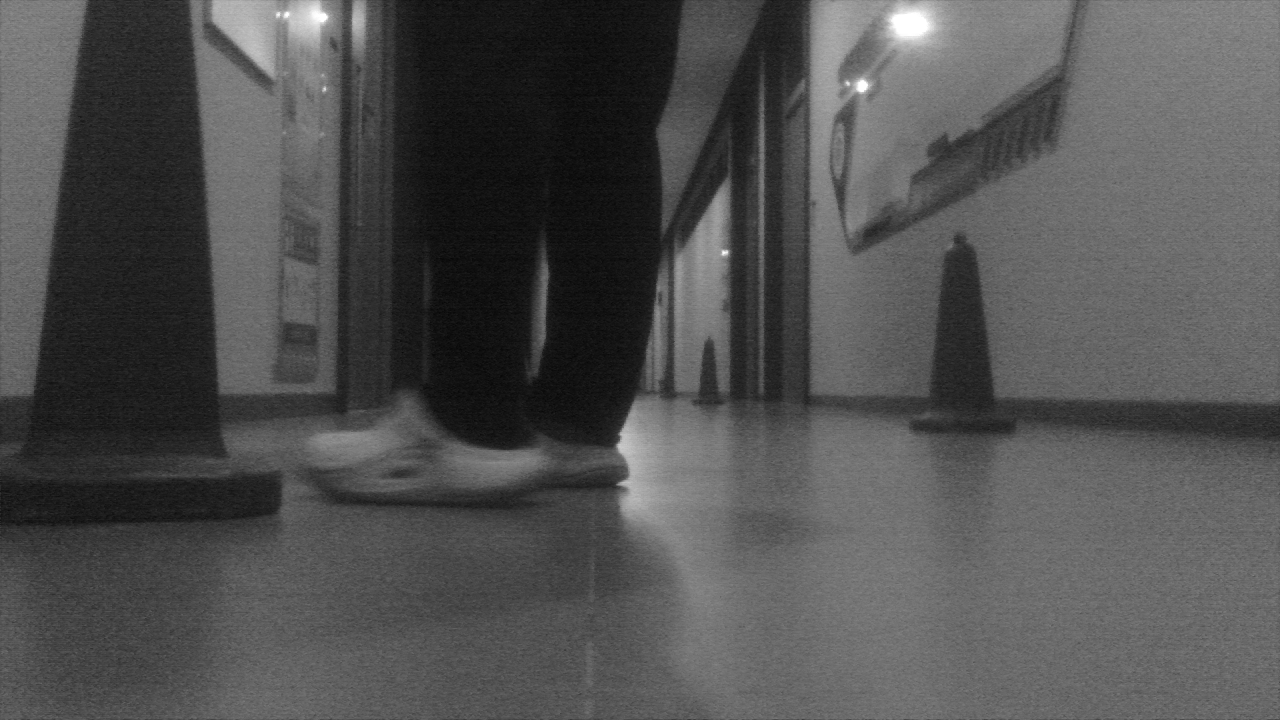

In [5]:
frame = overlay.OV5640.get_frame('gray')
imshow_gray(frame)
frame.freebuffer()

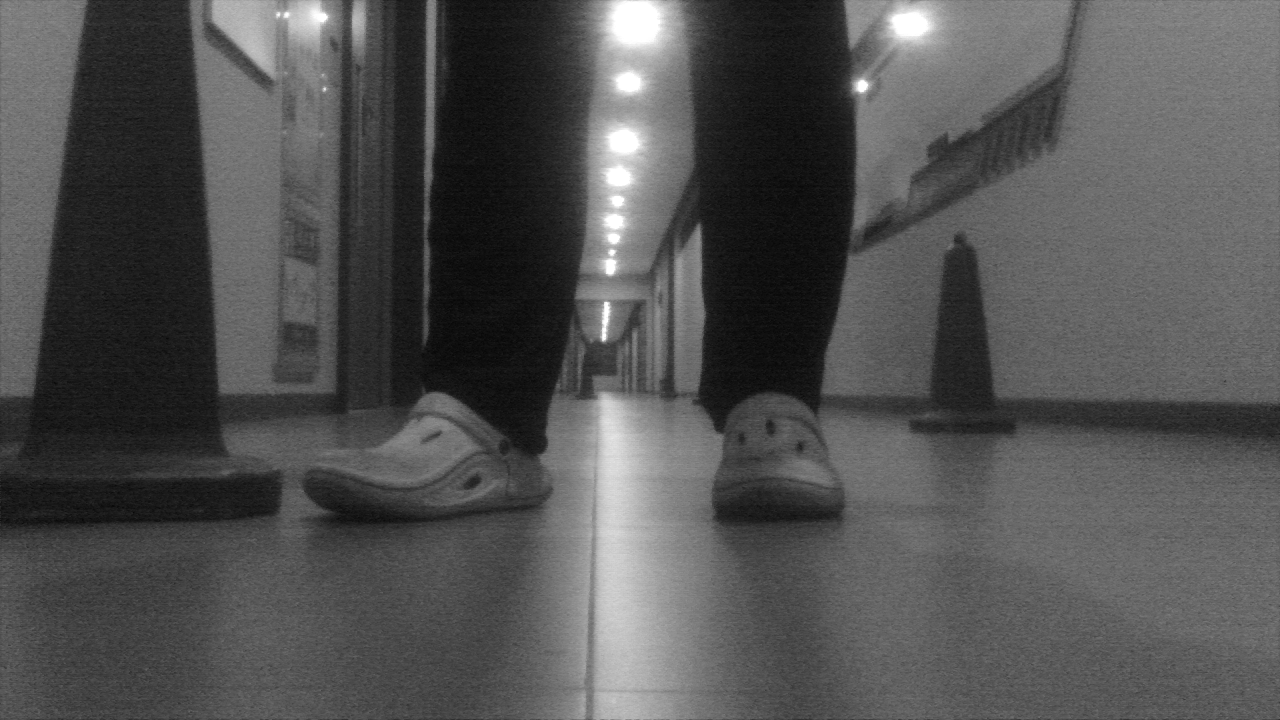

In [6]:
frame = OV5640.get_frame('gray')
res = video_proc.Bypass(frame)
imshow_gray(res)
frame.freebuffer()
res.freebuffer()

### 主函数

In [ ]:
pid = PIDController(kp=0.7, ki=0.00, kd=1.2, output_min=-60, output_max=60)

while True:
    image = overlay.OV5640.get_frame('gray')
    height, width = image.shape[:2]
    
#     image = video_proc.SobelX(image)
#     image = video_proc.Canny(image,50,70)
#    只取下面
    cv_height = height//3
    image = image[2*cv_height:, :]
    #二值化处理
    ret2, image = cv2.threshold(image, 70, 255, cv2.THRESH_BINARY_INV)  #+ cv2.THRESH_OTSU _INV

#     imshow_gray(image)      #显示图
    
    #分左，中，右三个区域
    part_width = width // 3
    
    left_part = image[:, 0:part_width]
    middle_part = image[:, part_width:part_width*2]
    right_part = image[:, part_width*2:]

    avg_intensity1 = np.mean(left_part)
    avg_intensity2 = np.mean(middle_part)
    avg_intensity3 = np.mean(right_part)
    
    #PID误差
    err = avg_intensity1 - avg_intensity3
    output = pid.compute(err)

    print("err:%.2f" %err)
    d = [avg_intensity1,avg_intensity2,avg_intensity3]
#     print(d)
#     print("output: %d" %output)
#     print("angle: %d" %angle)
#     print('avg_intensity2:%.2f' %avg_intensity2)
#     print("ret2: %d"%ret2)
    
    if 150 < avg_intensity2:
        if 220 < avg_intensity2 and avg_intensity1 > 220 and  avg_intensity3 > 220 and err < 10:
            angle = 60
        else:
            angle = output
    elif  avg_intensity2 <= 90:
        if err < -80:
            angle = -30  # 左转角度
        elif err > 80:
            angle = 30  # 右转角度
        else:
            angle = 5
    else:    # 直行
        angle = 5
    mc.set_direction(angle)
    print("angle: %d" %angle)
    
    mc.set_velocity(2000)

err:165.39
angle: 0


### 结束并停止一切功能

In [60]:
mc.set_velocity(0)
mc.set_direction(0.0)
hdmi_out.stop()
OV5640.stop()
video_proc.stop()